# Image classification workflow with distributed training
The following example demonstrates an end to end data science workflow for building an image classifier using Tensorflow in a Multi-Node settings.  

We use a public Cats & Dogs dataset to train a Tensorflow based model, and then deploy it to a Live endpoint where you can send an http request with an image of cats/dogs and get a response back that identify whether it is a cat or a dog.  

We also share some information about running distributed workloads in general, and how you can integrate easily with Horovod.

This typical data science workflow comprises of the following:

* Download anb label the dataset
* Training a model on the images dataset
* Deploy a function with the new model in a serving layer
* Testing the function

Key technologies (all open source):
* [Tensorflow-Keras](https://github.com/tensorflow/tensorflow) for training the model
* [Horovod](https://github.com/horovod/horovod) for running a distributed training
* [MLRun](https://github.com/mlrun/mlrun) for building the functions and tracking experiments
* [Nuclio](https://github.com/nuclio/nuclio) function for creating a funciton that runs the model in a serving layer

Based on:
* https://www.kaggle.com/c/dogs-vs-cats/overview


## Running distributed workloads

Training a Deep Neural Network is a hard task.  With growing datasets, wider and deeper networks, training our Neural Network can require a lot of resources (CPUs / GPUs / Mem and Time).  

There are two main reasons why we would like to distribute our Deep Learning workloads:  

1. **Model Parallelism** &mdash; The **Model** is too big to fit a single GPU.  
In this case the model contains too many parameters to hold within a single GPU.  
To negate this we can use strategies like **Parameter Server** or slicing the model into slices of consecutive layers which we can fit in a single GPU.  
Both strategies require **Synchronization** between the layers held on different GPUs / Parameter Server shards.  

2. **Data Parallelism** &mdash; The **Dataset** is too big to fit a single GPU.  
Using methods like **Stochastic Gradient Descent** we can send batches of data to our models for gradient estimation. This comes at the cost of longer time to converge since the estimated gradient may not fully represent the actual gradient.  
To increase the likelihood of estimating the actual gradient we could use bigger batches, by sending small batches to different GPUs running the same Neural Network, calculating the batch gradient and then running a **Synchronization Step** to calculate the average gradient over the batches and update the Neural Networks running on the different GPUs.  


> It is important to understand that the act of distribution adds extra **Synchronization Costs** which may vary according to your cluster's configuration.  
> <br>
> As the gradients and NN needs to be propagated to each GPU in the cluster every epoch (or a number of steps), Networking can become a bottleneck and sometimes different configurations need to be used for optimal performance.  
> <br>
> **Scaling Efficiency** is the metric used to show by how much each additional GPU should benefit the training process with Horovod showing up to 90% (When running with a well written code and good parameters).

![Horovod scaling](https://user-images.githubusercontent.com/16640218/38965607-bf5c46ca-4332-11e8-895a-b9c137e86013.png)

### How can we distribute our training
There are two different cluster configurations (which can be combined) we need to take into account.  
- **Multi Node** &mdash; GPUs are distributed over multiple nodes in the cluster.  
- **Multi GPU** &mdash; GPUs are within a single Node.  

In this demo we show a **Multi Node Multi GPU** &mdash; **Data Parallel** enabled training using Horovod.  
However, you should always try and use the best distribution strategy for your use case (due to the added costs of the distribution itself, ability to run in an optimized way on specific hardware or other considerations that may arise).

### How Horovod works?
Horovod's primary motivation is to make it easy to take a single-GPU training script and successfully scale it to train across many GPUs in parallel. This has two aspects:

- How much modification does one have to make to a program to make it distributed, and how easy is it to run it?
- How much faster would it run in distributed mode?

Horovod Supports TensorFlow, Keras, PyTorch, and Apache MXNet.

in MLRun we use Horovod with MPI in order to create cluster resources and allow for optimized networking.  
**Note:** Horovd and MPI may use [NCCL](https://developer.nvidia.com/nccl) when applicable which may require some specific configuration arguments to run optimally.

Horovod uses this MPI and NCCL concepts for distributed computation and messaging to quickly and easily synchronize between the different nodes or GPUs.

![Ring Allreduce Strategy](https://miro.medium.com/max/700/1*XdMlfmOgPCUG9ZOYLTeP9w.jpeg)

Horovod will run your code on all the given nodes (Specific node can be addressed via `hvd.rank()`) while using an `hvd.DistributedOptimizer` wrapper to run the **synchronization cycles** between the copies of your Neural Network running at each node.  

**Note:** Since all the copies of your Neural Network must be the same, Your workers will adjust themselves to the rate of the slowest worker (simply by waiting for it to finish the epoch and receive its updates). Thus try not to make a specific worker do a lot of additional work on each epoch (Like a lot of saving, extra calculations, etc...) since this can affect the overall training time.

### How do we integrate TF2 with Horovod?
As it's one of the main motivations, integration is fairly easy and requires only a few steps: ([You can read the full instructions for all the different frameworks on Horovod's documentation website](https://horovod.readthedocs.io/en/stable/tensorflow.html)).  

1. Run `hvd.init()`.  
2. Pin each GPU to a single process.
With the typical setup of one GPU per process, set this to local rank. The first process on the server will be allocated the first GPU, the second process will be allocated the second GPU, and so forth.  
``` gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')
```
3. Scale the learning rate by the number of workers.  
Effective batch size in synchronous distributed training is scaled by the number of workers. An increase in learning rate compensates for the increased batch size.
4. Wrap the optimizer in `hvd.DistributedOptimizer`.  
The distributed optimizer delegates gradient computation to the original optimizer, averages gradients using allreduce or allgather, and then applies those averaged gradients.  
For TensorFlow v2, when using a `tf.GradientTape`, wrap the tape in `hvd.DistributedGradientTape` instead of wrapping the optimizer.
1. Broadcast the initial variable states from rank 0 to all other processes.  
This is necessary to ensure consistent initialization of all workers when training is started with random weights or restored from a checkpoint.  
For TensorFlow v2, use `hvd.broadcast_variables` after models and optimizers have been initialized.
1. Modify your code to save checkpoints only on worker 0 to prevent other workers from corrupting them.  
For TensorFlow v2, construct a `tf.train.Checkpoint` and only call `checkpoint.save()` when `hvd.rank() == 0`.


You can go to [Horovod's Documentation](https://horovod.readthedocs.io/en/stable) to read more about horovod.

# Image classification use case

We start the project notebook by defining MLRun's environment and our current project

In [35]:
import nuclio
from os import environ, path
from mlrun import mlconf

# Define the `dbpath` - Where our `mlrun-api` services is available
# the `http://mlrun-api:8080` is auto-defined by `kubernetes service` definition 
mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'

# Define the artifact path for the current user's home directory
mlconf.artifact_path = mlconf.artifact_path or f'{environ["HOME"]}/artifacts'

# set tensorflow version (v1 or v2)
tf_ver = 'v2'

# specify paths and artifacts target location
code_dir = path.join(path.abspath('./'), 'src-tf' + tf_ver) # Where our source code files are saved
images_path = path.join(mlconf.artifact_path, 'images') 

# Specify the project's name for experiment tracking
project_name='cat-vs-dog-classification'

print(f'Code from {code_dir} will be used to train on the {images_path} given dataset')

Code from /User/demos/image-classification-with-distributed-training/src-tfv2 will be used to train on the v3io:///projects/{{run.project}}/artifacts/images given dataset


## Helper functions for downloading and labeling images
Our first task is to download and extract the dataset to a shared location where all our different nodes could access and run the training process using `Tensorflow`.  

In the following code block, we define the function `open_archive` which given our s3 `archive_url` downloads and extracts it to our wanted `images/<train/validation>/<label>` directory structure.  

We wrap the code block with our `# nuclio: start-code` and `# nuclio: end-code` annotations to let our MLRun parser know what code blocks are to be taken to our project function.

**Note:** sometimes after running pip install you need to restart the jupyer kernel

In [36]:
# nuclio: start-code

In [37]:
import os
import zipfile
import json
import shutil
from glob import glob
import pandas as pd
import numpy as np
from mlrun import DataItem
 
def open_archive(context, 
                 archive_url: DataItem,
                 target_path,
                 refresh=False,
                 train_size=0.8):
    """Open a file/object archive into a target directory
    
    Currently supports zip and tar.gz
    
    :param context:      function execution context
    :param archive_url:  url of archive file
    :param target_path:  file system path to store extracted files
    :param key:          key of archive contents in artifact store
    :param test_size:    set the train dataset size out of total dataset
    """
    os.makedirs(target_path, exist_ok=True)
    
    # get the archive as a local file (download if needed)
    archive_url = archive_url.local()
    
    context.logger.info('Extracting zip')
    extraction_path = os.path.join(target_path, 'tmp')
    zip_ref = zipfile.ZipFile(archive_url, 'r')
    zip_ref.extractall(extraction_path)
    
    # get all files paths from `extraction_path`
    filenames = [file for file in glob(extraction_path + '/*/*') if file.endswith('.jpg')]
    
    # extract labels from filenames by their naming convention (<label>.<number>.jpg)
    # and calculate how many images we have per label
    _extract_label = lambda filename: os.path.basename(filename).split('.')[0]
    file_labels = [_extract_label(file) for file in filenames]
    labels, label_counts = np.unique(file_labels, return_counts=True)
    
    # Order the files into a {<label>: [<files list>]} dictionary
    files = {label: [] for label in labels}
    for label, file in zip(file_labels, filenames):
        files[label].append(file)
    
    # Infer training dataset absolute size
    num_files = len(filenames)
    num_train = int(np.ceil(num_files * train_size))
    num_samples_per_class = int(np.ceil(num_train / len(labels)))
    
    # create directories for train and validation
    for label in labels:
        train_dir = os.path.join(target_path, "train", label)
        validation_dir = os.path.join(target_path, "validation", label)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(validation_dir, exist_ok=True)
    
    # move the files to their appropriate folders (<train/validation>/<label>/<file>)
    # we split the dataset by taking the first `num_samples_per_class` files from each
    # label and move them to `train` folder, and to `validation` after.
    _extract_detatset = lambda i, per_class: 'train' if i <= per_class else 'validation'
    for label, filenames in files.items():
        for i, file in enumerate(filenames):
            shutil.move(file, os.path.join(target_path, _extract_detatset(i, num_samples_per_class), label, os.path.basename(file)))
    shutil.rmtree(extraction_path)

    # Add function logging
    context.logger.info(f'extracted archive to {target_path}')
    context.logger.info(f'Dataset contains the labels {labels}')
    
    # Log the dataset folder as `content` artifact for later use
    context.log_artifact('content', target_path=target_path)

In [38]:
# nuclio: end-code

### Test locally, Download and extract image archive
After writing the function, we would like to test it locally first, as part of our development cycle.  
For that we can use MLRun's `run_local` which will run the function locally as if it was deployed remotely on the cluster, with all the related tracking. 
We then define a `NewTask` with the `open_archive` function handler and the needed parameters and run it.  

**Note:** The dataset is taken from the Iguazio-sample bucket in S3 <br>

If you would like to change the location of the source data, set the `SAMPLE_DATA_SOURCE_URL_PREFIX` environment variable.

For example, set it to `/v3io/projects/demos-data/iguazio/`

In [41]:
# download images from s3 using the local `open_archive` function
from mlrun import NewTask, run_local
import os

# Set the source-data URL
url_prefix = os.environ.get('SAMPLE_DATA_SOURCE_URL_PREFIX', 'https://s3.wasabisys.com/iguazio/')

open_archive_task = NewTask(name='download', 
                            handler=open_archive, 
                            params={'target_path': os.path.abspath('./images')},
                            inputs={'archive_url': f'{url_prefix.rstrip("/")}/data/image-classification/catsndogs.zip'})


download_run = run_local(open_archive_task, 
                         project=project_name)

> 2021-05-30 07:24:33,452 [info] starting run download uid=1c34dcde777f4c0f83e9c84197b8ad0c DB=http://mlrun-api:8080
> 2021-05-30 07:24:33,543 [info] Extracting zip
> 2021-05-30 07:24:57,492 [info] extracted archive to /User/demos/image-classification-with-distributed-training/images
> 2021-05-30 07:24:57,493 [info] Dataset contains the labels ['cat' 'dog']


to track results use .show() or .logs() or in CLI: 
!mlrun get run 1c34dcde777f4c0f83e9c84197b8ad0c --project cat-vs-dog-classification , !mlrun logs 1c34dcde777f4c0f83e9c84197b8ad0c --project cat-vs-dog-classification
> 2021-05-30 07:24:57,622 [info] run executed, status=completed


# Complete Data-Science Pipeline with MLRun and Kubeflow


## Create a multi-stage project (ingest, label, train, deploy model)

Projects are used to package multiple functions, workflows, and artifacts. We usually store project code and definitions in a Git archive.

The following code creates a new project in a local dir and initialize git tracking on that

In [42]:
from mlrun import new_project, code_to_function
project_dir = './'
hvdproj = new_project(project_name, project_dir)

#### Add our `utils` function to the project
After we locally testing our function, we convert our inline (notebook) code to a function object and register that under our project

In [43]:
utils = code_to_function(kind='job', 
                         name='utils',
                         image='mlrun/mlrun')

In [44]:
hvdproj.set_function(utils)

### Define a new function for distributed Training with TensorFlow, Keras and Horovod

Here we use the same structure as before to deploy our **[cats vs. dogs tensorflow model training file](./src-tfv2/horovod-training.py)** to run on the defined horovod cluster in a distributed manner.  

In this demo, we apply Transfer Learning from a `ResNet50V2` pre-trained on imagenet model, with an added custom classification layer:
```
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation="relu", kernel_initializer="he_uniform")(flat1)
output = Dense(1, activation="sigmoid")(class1)
```
We also apply basic Tensorflow Dataset optimisations such as `prefatch` for faster training times.

To create a distributed training function, simply:  

1. Define the input parameters for the training function.  
2. Set the function's `kind='mpijob'` to let MLRun know to apply the job to the MPI CRD and create the requested horovod cluster.  
3. Set the number of workers for the horovod cluster to use by setting `trainer.spec.replicas = 4` (default is 1 replica).  

#### To run training using GPUs
To provide GPU support for our workers we need to edit the following:
1. Set the function image to a CUDA enabled image (Required) with GPU versions of the frameworks (if needed - TF 1.x gpu version for example)
2. Set the number of GPUs **each worker** will receive by setting `trainer.gpus(1)` (default is 0 GPUs).

> You can change `use_gpu` to `True` to enable GPU support with 1 gpu/worker  

> Please verify that the `HOROVOD_FILE` path is available from the cluster (Local path and Mounted path may vary)

The code in [horovod-training.py](./src-tfv2/horovod-training.py) is already written with Horovod and TF2 guidelines as listed in [Horovod's Tensorflow integration guidelines](https://horovod.readthedocs.io/en/stable/tensorflow.html) and you can inspect it as an example.

> Please verify that the HOROVOD_FILE path is available from the cluster (Local path and Mounted path may vary)

In [45]:
HOROVOD_FILE = os.path.join(code_dir, 'horovod-training.py')
print(HOROVOD_FILE)

/User/demos/image-classification-with-distributed-training/src-tfv2/horovod-training.py


In [46]:
from mlrun import new_function
import os

# Set `use_gpu` to True to run the function using a GPU Configuration
use_gpu = False

image = lambda gpu: 'mlrun/ml-models-gpu' if gpu else 'mlrun/ml-models' 

# Set basic function parameters
trainer = new_function(name='trainer',
                       kind='mpijob',
                       command=HOROVOD_FILE)
trainer.spec.replicas = 2

# Set a minimal number of dedicated CPUs per node
trainer.with_requests(cpu=4)

# Pick image by wanted TF version
if tf_ver == 'v1':
    trainer.spec.image = f'{image(use_gpu)}:{mlconf.version}-py36'
else:
    trainer.spec.image = image(use_gpu)
    
# Add GPUs to workers?
if use_gpu:
    trainer.gpus(1)

# Registre the function to the project
hvdproj.set_function(trainer)

#### Add a serving function from the functions hub (marketplace)

In [47]:
if tf_ver == 'v1':
    hvdproj.set_function('hub://tf1_serving', 'serving')
else:
    hvdproj.set_function('hub://tf2_serving', 'serving')

#### Register the source images directory as a project artifact (can be accessed by name)
By registering the s3 dataset zip file as a project artifact, we are both registering it in the MLRun DB (which will show it in the UI).  
But mainly, we enable access to the artifact through our `store://` annotation.  

Through the `store://` we can request specific artifacts via `store://<project>/<artifact>` annotation.  
This enables us to set a specific artifact, like the latest dataset, Version and Update it, while keeping the same reference through the code.  
Specific versions or artifact tags can be accessed by adding `#<hash>` or `:<tag>`.

In [48]:
hvdproj.log_artifact(
    'images', 
    target_path=f'{url_prefix}data/image-classification/catsndogs.zip',
    artifact_path=mlconf.artifact_path)
#print(hvdproj.to_yaml())

#### Define and save a pipeline 

The following workflow definition will be written into a file, it describes an execution graph (DAG) and how functions are conncted to form an end to end pipline. 

* Download the images 
* Label the images (Cats & Dogs)
* Train the model using distributed TensorFlow (Horovod)
* Deploy the model into a serverless function 

In [64]:
%%writefile workflow.py
from kfp import dsl
from mlrun import mount_v3io

funcs = {}


def init_functions(functions: dict, project=None, secrets=None):
    '''
    This function will run before running the project.
    It allows us to add our specific system configurations to the functions
    like mounts or secrets if needed.

    In this case we will add Iguazio's user mount to our functions using the
    `mount_v3io()` function to automatically set the mount with the needed
    variables taken from the environment. 
    * mount_v3io can be replaced with mlrun.platforms.mount_pvc() for 
    non-iguazio mount

    @param functions: <function_name: function_yaml> dict of functions in the
                        workflow
    @param project: project object
    @param secrets: secrets required for the functions for s3 connections and
                    such
    '''
    for f in functions.values():
        f.apply(mount_v3io())                  # On Iguazio (Auto-mount /User)
        # f.apply(mlrun.platforms.mount_pvc()) # Non-Iguazio mount
        
    functions['serving'].set_env('MODEL_CLASS', 'TFModel')
    functions['serving'].set_env('IMAGE_HEIGHT', '224')
    functions['serving'].set_env('IMAGE_WIDTH', '224')
    functions['serving'].set_env('ENABLE_EXPLAINER', 'False')
    functions['serving'].spec.min_replicas = 1


@dsl.pipeline(
    name='Image classification demo',
    description='Train an Image Classification TF Algorithm using MLRun'
)
def kfpipeline(
        image_archive='store:///images',
        images_dir='/User/artifacts/images',
        checkpoints_dir='/User/artifacts/models/checkpoints',
        model_name='cat_vs_dog_tfv1',
        epochs: int=2):

    # step 1: download and prep images
    open_archive = funcs['utils'].as_step(name='download',
                                          handler='open_archive',
                                          params={'target_path': images_dir},
                                          inputs={'archive_url': image_archive},
                                          outputs=['content'])

    # step 2: train the model
    train_dir = str(open_archive.outputs['content']) + '/train'
    val_dir = str(open_archive.outputs['content']) + '/validation'
    train = funcs['trainer'].as_step(name='train',
                                     params={'epochs': epochs,
                                             'checkpoints_dir': checkpoints_dir,
                                             'model_dir'     : 'tfmodels',
                                             'train_path'     : train_dir,
                                             'val_path'       : val_dir,
                                             'batch_size'     : 32},
                                     outputs=['model'])

    # deploy the model using nuclio functions
    deploy = funcs['serving'].deploy_step(models={model_name: train.outputs['model']})


Overwriting workflow.py


In [65]:
hvdproj.set_workflow('main', 'workflow.py', embed=True)

In [66]:
hvdproj.save()

<a id='run-pipeline'></a>
## Run a pipeline workflow
You can check the **[workflow.py](./workflow.py)** file to see how functions objects are initialized and used (by name) inside the workflow.
The `workflow.py` file has two parts, initialize the function objects and define pipeline dsl (connect the function inputs and outputs).

> Note the pipeline can include CI steps like building container images and deploying models.



### Run
use the `run` method to execute a workflow, you can provide alternative arguments and specify the default target for workflow artifacts.<br>
The workflow ID is returned and can be used to track the progress or you can use the hyperlinks

> Note: The same command can be issued through CLI commands:<br>
    `mlrun project my-proj/ -r main -p "v3io:///users/admin/mlrun/kfp/{{workflow.uid}}/"`

The dirty flag allow us to run a project with uncommited changes (when the notebook is in the same git dir it will always be dirty)

In this cell we will run the `main` workflow via `KubeFlow Pipelines` on top of our cluster.  
Running the pipeline may take some time. Due to possible jupyter timeout, it's best to track the pipeline's progress via KFP or the MLRun UI.

In [67]:
artifact_path = path.abspath('./pipe/{{workflow.uid}}')
run_id = hvdproj.run(
    'main',
    arguments={'model_name': 'cat_vs_dog_tf' + tf_ver,
               'images_dir': artifact_path + '/images'}, 
    artifact_path=artifact_path, 
    dirty=True, watch=True)

> 2021-05-30 07:29:40,817 [info] Pipeline run id=cb163c63-49ea-4e9d-b13a-c1956c669997, check UI or DB for progress
> 2021-05-30 07:29:40,817 [info] waiting for pipeline run completion


## Test the serving function

After the function has been deployed we can test it as a regular REST Endpoint using `requests`.

In [68]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

### Define test params

Test image:


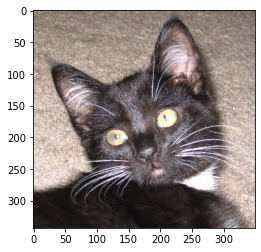

In [100]:
# Testing event
cat_image_url = f'{url_prefix}data/image-classification/cat.102.jpg'

if 'http' in cat_image_url:
    response = requests.get(cat_image_url)
    cat_image = response.content
    img = Image.open(BytesIO(cat_image))
else:
    cat_image = open(cat_image_url,'rb').read()
    img = Image.open(cat_image_url)

print('Test image:')
plt.imshow(img)

### Test The Serving Function (with Image URL)

In [ ]:
addr = 'http://nuclio-{}-{}:8080'.format(hvdproj.name, hvdproj.func('serving').metadata.name)

headers = {'Content-type': 'image/jpeg'}
url = addr + f'/cat_vs_dog_tf{tf_ver}/predict'

response = requests.post(url=url, 
                         data=json.dumps({'data_url': cat_image_url}), 
                         headers=headers)
print(response.content.decode('utf-8'))

In [74]:
%%timeit 
requests.post(url=url, 
              data=json.dumps({'data_url': cat_image_url}), 
              headers=headers)

The slowest run took 5.73 times longer than the fastest. This could mean that an intermediate result is being cached.
755 ms ± 245 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Test The Serving Function (with Jpeg Image)

In [98]:
headers = {'Content-type': 'image/jpeg'}
response = requests.post(url=url, 
                         data=cat_image, 
                         headers=headers)
print(response.content.decode('utf-8'))

[0.0]


In [99]:
%%timeit
requests.post(url=url, 
              data=cat_image, 
              headers=headers)

82 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**[back to top](#top)**